#  Introduction:
In this notebook we will go through Kaggle's Titanic dataset and use machine learning alghorithms to predict if a passanger in Titanic survived the disaster or not. During the process we will do an exploratory data analysis, future creation and selection, model creation and selection. This will be my first data science project after going through Kaggle's instructive notebooks and courses, without further ado let's get started.

In [1]:
#data analysis
import pandas as pd
import numpy as np
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
#plot graphs inline
%matplotlib inline


In [2]:
data_raw = pd.read_csv('trainTitanic.csv')
test_raw = pd.read_csv('testTitanic.csv')
# to avoid changing the original csv file, we create copies
data = data_raw.copy(deep = True)
print(data.shape)
test = test_raw.copy(deep = True)

(891, 12)


In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
data.shape

(891, 12)

In [6]:
features = data.columns.drop('Survived')
target = data.columns.drop(features)

In [7]:
#split our training data into train and validation sets before making any imputations to avoid leakage
from sklearn.model_selection import train_test_split

train_X, valid_X, train_y, valid_y = train_test_split(data[features], data[target], test_size=0.25, random_state=0)

#group for easier data cleaning
datas = [train_X, valid_X, test]

print("train_X dimensions:{0} ".format(train_X.shape))
print("valid_X dimensions:{0} " .format(valid_X.shape))
print("test dimensions: {0}".format(test.shape))

train_X dimensions:(668, 11) 
valid_X dimensions:(223, 11) 
test dimensions: (418, 11)


In [8]:
catagoric = train_X.loc[:, train_X.dtypes == object].columns.tolist()
numeric = train_X.loc[:, train_X.dtypes != object].columns.tolist()

In [9]:
data.shape

(891, 12)

In [10]:
train_X.isna().mean()

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.199102
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.764970
Embarked       0.002994
dtype: float64

In [11]:
# over 3 quarters of cabin data in training data is missing so dropping the feature is a viable option
catagoric.remove('Cabin')
for d in datas:
    d.drop(['Cabin'], axis=1, inplace= True)

In [12]:
data.shape

(891, 12)

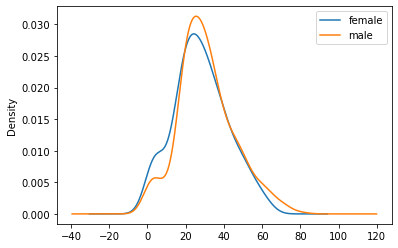

In [13]:
# we will impute missing Age values with 
data.groupby('Sex').Age.plot(kind='kde')
plt.legend()
# male and female passangers both have a very close median but it might still be benefitial to impute them acording to their groups
# also impute Embarked with the mode
for d in datas:
    d['Age'] = d.groupby('Sex').Age.apply(lambda x: x.fillna(x.mean()))
    d['Embarked'] = d['Embarked'].fillna(d.Embarked.mode()[0])

In [14]:
for d in datas:
    print(d.isnull().any())
    print('-'*40)
#some Fare prices are missing in test data, we will impute them acording to their Pclass

PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Embarked       False
dtype: bool
----------------------------------------
PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Embarked       False
dtype: bool
----------------------------------------
PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare            True
Embarked       False
dtype: bool
----------------------------------------


In [15]:
test.Fare = test.groupby('Pclass').Fare.apply(lambda x: x.fillna(x.mean()))
for d in datas:
    print(d.isnull().any())

PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Embarked       False
dtype: bool
PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Embarked       False
dtype: bool
PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Embarked       False
dtype: bool


Now we have handled the missing values, lets get to work with categorical features, and encode them so our model is able to use them.

In [16]:
print(data.loc[:, catagoric].nunique())
print(data.shape[0])

Name        891
Sex           2
Ticket      681
Embarked      3
dtype: int64
891


In [17]:

for d in datas:
    # ticket is way too complicated of a feature to handle in this notebook, and it mostly seems to be random unique values,
    # it will be dropped
    d.drop(['Ticket'], inplace= True, axis = 1)
    